# Modèle en eau peu profonde linéarisé

**Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2022. D'après un code original de James Penn modifié par G. K. Vallis.**

<img src="sw.png" width="800">

Le **modèle en eau peu profonde** (« shallow-water ») est un modèle de fluide homogène. C’est un modèle barotrope divergent que l’on obtient en réduisant sur un seul niveau les équations primitives. Bien que simplifiée, la dynamique décrite par les trois équations de ce modèle (équations de Saint-Venant) **contient l'essentiel des processus dynamiques mis en jeu dans l'atmosphère : l’advection, la rotation, ainsi que l’ajustement de la surface libre du fluide suite à la propagation des ondes de gravité**.

L’objectif de ce TP est d’**étudier l’ajustement d’un modèle en eau peu profonde que l’on perturbe à l’état initial**. On examinera la solution transitoire qui se propage dans le modèle ainsi que l’état stationnaire obtenu après un certain temps d’intégration. On analysera l’influence rotation sur le processus d’ajustement. Enfin, on étudiera les solutions du modèle dans le cas particulier du β-plan équatorial.

Le code Python ci-dessous traite numériquement le système d’équations de Saint-Venant linéarisé autour d'un état de base au repos (u=v=0, h=H=D)

$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}-fv=-g\frac{\partial h}{\partial x}-{\kappa}u+{\nu}(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 v}{\partial y^2})+F$

$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}+fu=-g\frac{\partial h}{\partial y}-{\kappa}v+{\nu}(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 v}{\partial y^2})+F$

$\frac{\partial h}{\partial t}+\frac{\partial ((H+h)u)}{\partial x}+\frac{\partial ((H+h)v)}{\partial y})=F$

$η =h - D + h_B$

$f = f_0 + βy$

F est un forçage, par défaut F = (0, 0, 0)

In [153]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob
from tqdm import tqdm
import sys
import scipy.io as sio
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio
from scipy.interpolate import RegularGridInterpolator

# Fonctions

<div class="alert alert-success">
<b>A modifier selon les simulations souhaitées. </b>
</div>

In [154]:
experiment = '2d'           # set to '1d' or '2d'

## CONFIGURATION
### Domain
nx = 254
ny = 50
dx = 111.86e3
dy = 100.00e3


#b = 900.*2.*np.abs((np.mean(x)-X)/np.max(x))          # [m]  Average depth of the fluid
#b=np.roll(b,110,axis=0)

Lx = nx*dx          # [m]  Zonal width of domain
Ly = ny*dy          # [m]  Meridional height of domain

boundary_condition = 'earth'  # either 'earth' or 'walls'
if experiment == '1d':
    boundary_condition = 'walls'

### Coriolis and Gravity
g = 1.0               # [m.s^-1]
f0 = 1e-4          # [s^-1] f = f0 + beta y
beta =  1.6e-11         # [m^-1.s^-1]

### Diffusion and Friction (not used)
nu = 5.0e4*0          # [m^2.s^-1] Coefficient of diffusion
r = 1.0e-4*0          # Rayleigh damping at top and bottom of domain

### Simulation parameters
dt = 60      # Timestep [s]
nsteps = 10000    # number of timesteps (4 days)
plot_interval = 400 #plot every n steps

<div class="alert alert-danger">
<b>Ne pas modifier. </b>
</div>

In [155]:
## GRID
# Setup the Arakawa-C Grid:
#
# +-- v --+
# |       |    * (nx, ny)   h points at grid centres
# u   η   u    * (nx+1, ny) u points on vertical edges  (u[0] and u[nx] are boundary values)
# |       |    * (nx, ny+1) v points on horizontal edges
# +-- v --+
#
# Variables preceeded with underscore  (_u, _v, _η) include the boundary values,
# variables without (u, v, η) are a view onto only the values defined
# within the domain
_u = np.zeros((nx+3, ny+2))
_v = np.zeros((nx+2, ny+3))
_η = np.zeros((nx+2, ny+2))

u = _u[1:-1, 1:-1]               # (nx+1, ny)
v = _v[1:-1, 1:-1]               # (nx, ny+1)
η = _η[1:-1, 1:-1]               # (nx, ny)

state = np.array([u, v, η], dtype=object)

dx = Lx / nx            # [m]
dy = Ly / ny            # [m]

# positions of the value points in [m]
ux = (-Lx/2 + np.arange(nx+1)*dx)[:, np.newaxis]
vx = (-Lx/2 + dx/2.0 + np.arange(nx)*dx)[:, np.newaxis]

vy = (-Ly/2 + np.arange(ny+1)*dy)[np.newaxis, :]
uy = (-Ly/2 + dy/2.0 + np.arange(ny)*dy)[np.newaxis, :]

ηx = vx
ηy = uy

## GRID FUNCTIONS
# These functions perform calculations on the grid such as calculating
# derivatives of fields or setting boundary conditions

def update_boundaries():

    # 1. Periodic Boundaries
    #    - Flow cycles from left-right-left
    #    - u[0] == u[nx]
    if boundary_condition == 'periodic':
        _u[0, :] = _u[-3, :]
        _u[1, :] = _u[-2, :]
        _u[-1, :] = _u[2, :]
        _v[0, :] = _v[-2, :]
        _v[-1, :] = _v[1, :]
        _η[0, :] = _η[-2, :]
        _η[-1, :] = _η[1, :]

    # 2. Solid walls left and right
    #    - No zonal (u) flow through the left and right walls
    #    - Zero x-derivative in v and η
    if boundary_condition == 'walls':
        # No flow through the boundary at x=0
        _u[0, :] = 0
        _u[1, :] = 0
        _u[-1, :] = 0
        _u[-2, :] = 0
        _v[:,-1] = 0
        _v[:,-2] = 0
        _v[:,-3] = 0
        _v[:,0] = 0
        _v[:,1] = 0
        
        # free-slip of other variables: zero-derivative
        _v[0, :] = _v[1, :]
        _v[-1, :] = _v[-2, :]
        _η[0, :] = _η[1, :]
        _η[-1, :] = _η[-2, :]
     
    # 3. Solid walls left and right
    #    - No meridian (v) flow through the up and down walls
    #    - periodic zonal η 
    
    if boundary_condition == 'earth':
        
        #Left/Right
        _u[0, :] = _u[-3, :]
        _u[1, :] = _u[-2, :]
        _u[-1, :] = _u[2, :]
        _v[0, :] = _v[-2, :]
        _v[-1, :] = _v[1, :]
        
        #Bottom 
        _u[:,0]=_u[:,2]
        _u[:,1]=_u[:,3]
            # No meridian flow througt the axis y=0
        _v[:,0] = 0
        _v[:,1] = 0
        
        #Top
        _u[:,-1]=_u[:,-3]
        _u[:,-2]=_u[:,-4]
            # No meridian flow througt the axis y=-1 
        _v[:,-1] = 0
        _v[:,-2] = 0

        
        

        
        
        #imposition of initial conditions at the top and bottom
        _η[:,0]=η0[:,0]
        _η[:,1]=η0[:,1]
        _η[:,-1]=η0[:,-1]
        _η[:,-2]=η0[:,-2]
        
        #periodic h trought right and left border
        _η[0, :] = _η[-2, :]
        _η[-1, :] = _η[1, :]
        
        


def diffx(psi):
    """Calculate ∂/∂x[psi] over a single grid square.

    i.e. d/dx(psi)[i,j] = (psi[i+1/2, j] - psi[i-1/2, j]) / dx

    The derivative is returned at x points at the midpoint between
    x points of the input array."""
    global dx
    return (psi[1:,:] - psi[:-1,:]) / (dx)



def diff2x(psi):
    """Calculate ∂2/∂x2[psi] over a single grid square.

    i.e. d2/dx2(psi)[i,j] = (psi[i+1, j] - psi[i, j] + psi[i-1, j]) / dx^2

    The derivative is returned at the same x points as the
    x points of the input array, with dimension (nx-2, ny)."""
    global dx
    return (psi[:-2, :] - 2*psi[1:-1, :] + psi[2:, :]) / dx**2

def diff2y(psi):
    """Calculate ∂2/∂y2[psi] over a single grid square.

    i.e. d2/dy2(psi)[i,j] = (psi[i, j+1] - psi[i, j] + psi[i, j-1]) / dy^2

    The derivative is returned at the same y points as the
    y points of the input array, with dimension (nx, ny-2)."""
    global dy
    return (psi[:, :-2] - 2*psi[:, 1:-1] + psi[:, 2:]) / dy**2

def diffy(psi):
    """Calculate ∂/∂y[psi] over a single grid square.

    i.e. d/dy(psi)[i,j] = (psi[i, j+1/2] - psi[i, j-1/2]) / dy

    The derivative is returned at y points at the midpoint between
    y points of the input array."""
    global dy
    return (psi[:, 1:] - psi[:,:-1]) / (dy)

def centre_average(phi):
    """Returns the four-point average at the centres between grid points."""
    return 0.25*(phi[:-1,:-1] + phi[:-1,1:] + phi[1:, :-1] + phi[1:,1:])

def y_average(phi):
    """Average adjacent values in the y dimension.
    If phi has shape (nx, ny), returns an array of shape (nx, ny - 1)."""
    return 0.5*(phi[:,:-1] + phi[:,1:])

def x_average(phi):
    """Average adjacent values in the x dimension.
    If phi has shape (nx, ny), returns an array of shape (nx - 1, ny)."""
    return 0.5*(phi[:-1,:] + phi[1:,:])

def divergence_h():
    """Returns the horizontal div(h*V) at η points."""
    _h=_η+10000-b[:-1,:-1]
    h=η+10000-b[1:-2,1:-2]
    
    _h=centre_average(_h)
    
    #return h*diffx(u) + diffx(_h[1:,1:-1])*u[:-1] +  h*diffy(v) + diffy(_h[1:-1,1:])*v[:,:-1] 
    #return diffx(u*(H[1:-1,1:-2]+_h[1:,1:-1])) +  diffy(v*(H[1:-2,1:-1]+_h[1:-1,1:])) 
    
    return diffx(u*y_average(_h)) +  diffy(v*x_average(_h))

    
    
def divergence():
    """Returns the horizontal divergence at h points."""
    
    return diffx(u) + diffy(v) 
 
    
    

def del2(phi):
    """Returns the Laplacian of phi."""
    return diff2x(phi)[:, 1:-1] + diff2y(phi)[1:-1, :]

def uvatuv():
    """Calculate the value of u at v and v at u."""
    global _u, _v
    ubar = centre_average(_u)[1:-1, :]
    vbar = centre_average(_v)[:, 1:-1]
    return ubar, vbar

def uvath():
    global u, v
    ubar = x_average(u)
    vbar = y_average(v)
    return ubar, vbar

def absmax(psi):
    return np.max(np.abs(psi))

<div class="alert alert-danger">
<b>Ne pas modifier. </b>
</div>

In [156]:
## DYNAMICS
# These functions calculate the dynamics of the system we are interested in
def forcing():
    """Add some external forcing terms to the u, v and η equations.
    This function should return a state array (du, dv, dη) that will
    be added to the RHS of equations (1), (2) and (3) when
    they are numerically integrated."""
    global u, v, η
    du = np.zeros_like(u)
    dv = np.zeros_like(v)
    dη = np.zeros_like(η)
    # Calculate some forcing terms here...
    return np.array([du, dv, dη], dtype=object)

sponge_ny = ny//7
sponge = np.exp(-np.linspace(0, 5, sponge_ny))
def damping(var):
    # sponges are active at the top and bottom of the domain by applying Rayleigh friction
    # with exponential decay towards the centre of the domain
    global sponge, sponge_ny
    var_sponge = np.zeros_like(var)
    var_sponge[:, :sponge_ny] = sponge[np.newaxis, :]
    var_sponge[:, -sponge_ny:] = sponge[np.newaxis, ::-1]
    return var_sponge*var

def rηs():
    """Calculate the right hand side of the u, v and h equations."""
    u_at_v, v_at_u = uvatuv()   # (nx, ny+1), (nx+1, ny)

    # the height equation
    η_rhs = -divergence_h() + nu*del2(_η) - r*damping(η)

    # the u equation
    dηdx = diffx(_η)[:, 1:-1]               # (nx+1, ny)
    __u=centre_average(_u)                  #(nx+2,ny+1)
    _u_=centre_average(centre_average(_u))  #(nx+1,ny)
    
    

    u_rhs = (f0 + beta*uy)*v_at_u - g*dηdx - _u_*diffx(y_average(__u)) - v_at_u*diffy(x_average(__u))+ nu*del2(_u) - r*damping(u)
    
    
    #dux_=centre_average(diffx(_u))
    #dvx_=centre_average(diffx(_v))
    #duy_=centre_average(diffy(_u))
    #dvy_=centre_average(diffy(_v))
    
    
    
    #u_rhs = (f0 + beta*uy)*v_at_u - g*dηdx - _u_*y_average(dux_) - v_at_u*x_average(duy_)+ nu*del2(_u) - r*damping(u)

    # the v equation
    dηdy  = diffy(_η)[1:-1, :]              # (nx, ny+1)
    _v_=centre_average(centre_average(_v))  #(nx,ny+1)
    __v=centre_average(_v)                  #(nx+1,ny+2)
    
    
    v_rhs = -(f0 + beta*vy)*u_at_v - g*dηdy - u_at_v*diffx(y_average(__v))-_v_*diffy(x_average(__v)) + nu*del2(_v) - r*damping(v)

    
    #v_rhs = -(f0 + beta*vy)*u_at_v - g*dηdy - u_at_v*y_average(dvx_) - _v_*x_average(dvy_) + nu*del2(_v) - r*damping(v)

    return np.array([u_rhs, v_rhs, η_rhs], dtype=object) + forcing()

_ppdstate, _pdstate = 0,0
def step():
    global dt, t, tc, _ppdstate, _pdstate

    update_boundaries()

    dstate = rηs()

    # take adams-bashforth step in time
    if tc==0:
        # forward euler
        dt1 = dt
        dt2 = 0.0
        dt3 = 0.0
    elif tc==1:
        # AB2 at step 2
        dt1 = 1.5*dt
        dt2 = -0.5*dt
        dt3 = 0.0
    else:
        # AB3 from step 3 on
        dt1 = 23./12.*dt
        dt2 = -16./12.*dt
        dt3 = 5./12.*dt

    newstate = state + dt1*dstate + dt2*_pdstate + dt3*_ppdstate
    u[:], v[:], η[:] = newstate
    _ppdstate = _pdstate
    _pdstate = dstate

    t  += dt
    tc += 1    

<div class="alert alert-danger">
<b>Ne pas modifier. </b>
</div>

In [157]:
def plot_all(u,v,h):
    fig.suptitle("t="+str(int(t))+' s ('+str(round(t/86400,2))+ ' days)', fontsize=16)
    plt.subplot(222)
    X, Y = np.meshgrid(ux, uy)
    plt.contourf(X/Lx, Y/Ly, u.T, cmap="RdBu", levels=colorlevels*absmax(u))
    plt.colorbar()
    plt.title('Zonal wind (u)')

    plt.subplot(224)
    X, Y = np.meshgrid(vx, vy)
    plt.contourf(X/Lx, Y/Ly, v.T, cmap="RdBu", levels=colorlevels*absmax(v))
    plt.colorbar()
    plt.title('Meridional wind (v)')

    plt.subplot(221)
    X, Y = np.meshgrid(ηx, ηy)
    plt.contourf(X/Lx, Y/Ly, η.T, cmap="RdBu", levels=colorlevels*absmax(η))
    #plt.quiver(X[:128:5,:128:5]/Lx, Y[:128:5,:128:5]/Ly, u[:128:5,:128:5].T, v[:128:5,:128:5].T,
    #          scale=0.2, units="xy")
    #plt.imshow( η.T+10000-h0.T[1:-1,1:-1],cmap='RdBu_r')
    plt.colorbar()
    plt.title('Height (η)')
    clevs_oro = np.arange(0, 10, 1)
    plt.contour(X/Lx, Y/Ly, (b[1:-2,1:-2]).T/1e3, clevs_oro,colors='black', linewidths=0.5)
    
    plt.subplot(223)
    plt.plot(ηx/Lx, η[:, ny//2])
    plt.xlim(-0.5, 0.5)
    plt.ylim(-absmax(η), absmax(η))
    plt.title('Height along x=0')

def plot_geo_adj(u, v, η):
        η0max = absmax(η0)
        fig.suptitle("t="+str(int(t))+' s ('+str(round(t/86400,2))+ ' days)', fontsize=16)
        plt.subplot(311)
        plt.plot(ηx, η[:, ny//2], 'b', linewidth=2)
        plt.plot(ηx, η0[:], 'r--', linewidth=1,)
        plt.ylabel('Height (η)')
        plt.ylim(-η0max*1.2, η0max*1.2)

        plt.subplot(312)
        plt.plot(vx, v[:, ny//2].T, linewidth=2)
        plt.plot(vx, v0[:, ny//2], 'r--', linewidth=1,)
        plt.ylabel('Meridional wind (v)')
        plt.ylim(-η0max*.12, η0max*.12)

        plt.subplot(313)
        plt.plot(ux, u[:, ny//2], linewidth=2)
        plt.plot(ux, u0[:, ny//2], 'r--', linewidth=1,)
        plt.xlabel('x/L$_\mathsf{x}$',size=16)
        plt.ylabel('Zonal wind (u)')
        plt.ylim(-η0max*.12, η0max*.12)

def make_animation(gif_filepath):
    from PIL import Image
    import os
    from IPython.display import Image as IPImage
    from IPython.display import display
    import time
    
    image_folder = dir_figs # répertoire contenant les fichiers PNG
    output_file = gif_filepath # nom du fichier de sortie
    animation_speed = 0.2 # vitesse de l'animation en secondes
    
    # Liste tous les fichiers PNG dans le répertoire image_folder
    files = sorted(os.listdir(image_folder),key=str.lower)
    image_files = [f for f in files if f.endswith('.png')]
    
    # Ouvre chaque fichier PNG et ajoute l'image à une liste
    images = []
    for filename in image_files:
        img = Image.open(os.path.join(image_folder, filename))
        images.append(img)
    images=images[::-1]
    # Crée l'animation GIF
    images[0].save(output_file, save_all=True, append_images=images[1:], duration=int(animation_speed*1000), loop=0)
    # Affiche l'animation GIF dans Jupyter
    with open(output_file,'rb') as f:
        display(IPImage(data=f.read(), format='png'))
    # Efface les fichiers PNG
    #for filename in image_files:
    #    os.remove(image_folder+filename)
    

<div class="alert alert-success">
<b>A modifier selon les simulations souhaitées. </b>
</div>

In [158]:
x = np.linspace(0, Lx, int(nx+3)); # Zonal distance coordinate (m)
y = np.linspace(0, Ly, int(ny+3)); # Meridional distance coordinate (m)
y = y - np.mean(y) # y=0 in the middle of its domain

Y,X= np.meshgrid(y, x); # Create matrices of the coordinate variables

# Coriolis parameter as a matrix of values varying in y only
F = f0+beta*Y # Y is zero in the middle of its range

# Create the orography field "H" --> Gaussian mountain
std_mountain_x = 6.*dx; # Std. dev. of mountain in x direction (m)
std_mountain_y = 6.*dy; # Std. dev. of mountain in y direction (m)
b=5000.*np.exp(-0.5*((X-np.mean(x))/std_mountain_x)**2-0.5*((Y-np.mean(y))/std_mountain_y)**2.);
H=10000-b



# Create the initial height field --> Uniform Westerly
mean_wind_speed = 20.; # m/s   
    # note change from original code
h0= 10000-(mean_wind_speed*f0/g)*Y-0.5*(mean_wind_speed*beta/g)*Y**2

η0 = h0[:-1,:-1] - 10000


# Create initial wind --> Geostrophic
u0=np.zeros((nx+3, ny+3));
v0=np.zeros((nx+3, ny+3));



#INITIALLY GEOSTROHPIC

# Centred spatial differences to compute geostrophic wind
u0[:,1:-1] = -(0.5*g/(F[:,1:-1]*dy))*(h0[:,2:]-h0[:,0:-2]);
        
# added to original
u0[:,0] = (u0[ :,1] + u0[:,2])/2
u0[:,-1] = (u0[:,-2] + u0[:,-3])/2
        
v0[1:-1,:] = (0.5*g/(F[1:-1,:]*dy))*-1*(h0[2:,:]-h0[0:-2,:]);
# Zonal wind is periodic so set u(1) and u(end) as dummy points that
# replicate u(end-1) and u(2), respectively
u0[[0 ,-1],:] = u0[[1 ,-2],:];
    
# Meridional wind must be zero at the north and south edges of the
# channel 
v0[:,:] = 0.;



boundary_condition = 'earth'  # either 'earth' or 'walls'




# set the variable fields to the initial conditions
u[:] = u0[1:-1,1:-2]
v[:] = v0[1:-2,1:-1]
b=b
H=H
η[:] = η0[0:-2,0:-2]

<div class="alert alert-success">
<b>A modifier pour chaque nouvelle simulation. </b>
</div>

In [160]:
dir_figs="montagne_gaussienne_nonlinearshallowwater"
os.makedirs(dir_figs)

In [161]:
## PLOTTING
# Create several functions for displaying current state of the simulation
# Only one is used at a time - this is assigned to `plot`


# create a set of color levels with a slightly larger neutral zone about 0
nc = 12
colorlevels = np.concatenate([np.linspace(-1, -.05, nc), np.linspace(.05, 1, nc)])

plot = plot_all
if experiment == '1d':
    plot = plot_geo_adj
    
## RUN
# Run the simulation and plot the state
#c = time.perf_counter()

t = 0.0                 # [s] Time since start of simulation
tc = 0                  # [1] Number of integration steps taken
cpt_img=0
for i in tqdm(range(nsteps)):
    step()
    if i % plot_interval == 0:
        
        fig = plt.figure(figsize=(8*Lx/Ly, 8))  # create a figure with correct aspect ratioηmax = np.max(np.abs(η))
        plot(*state)
        #print('[t={:7.2f} s u: [{:.3f}, {:.3f}], v: [{:.3f}, {:.3f}], η: [{:.3f}, {:.2f}]'.format(t,u.min(), u.max(),v.min(), v.max(),η.min(), η.max()))
        figname=dir_figs+'/geo_adj_0'+ str(nsteps-cpt_img)
        plt.savefig(figname+'.png')
        #plt.show()
        plt.close()
        plt.clf()
        cpt_img+=1
        #print('fps: %r' % (tc / (time.perf_counter()-c)))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:32<00:00, 107.62it/s]


<Figure size 640x480 with 0 Axes>

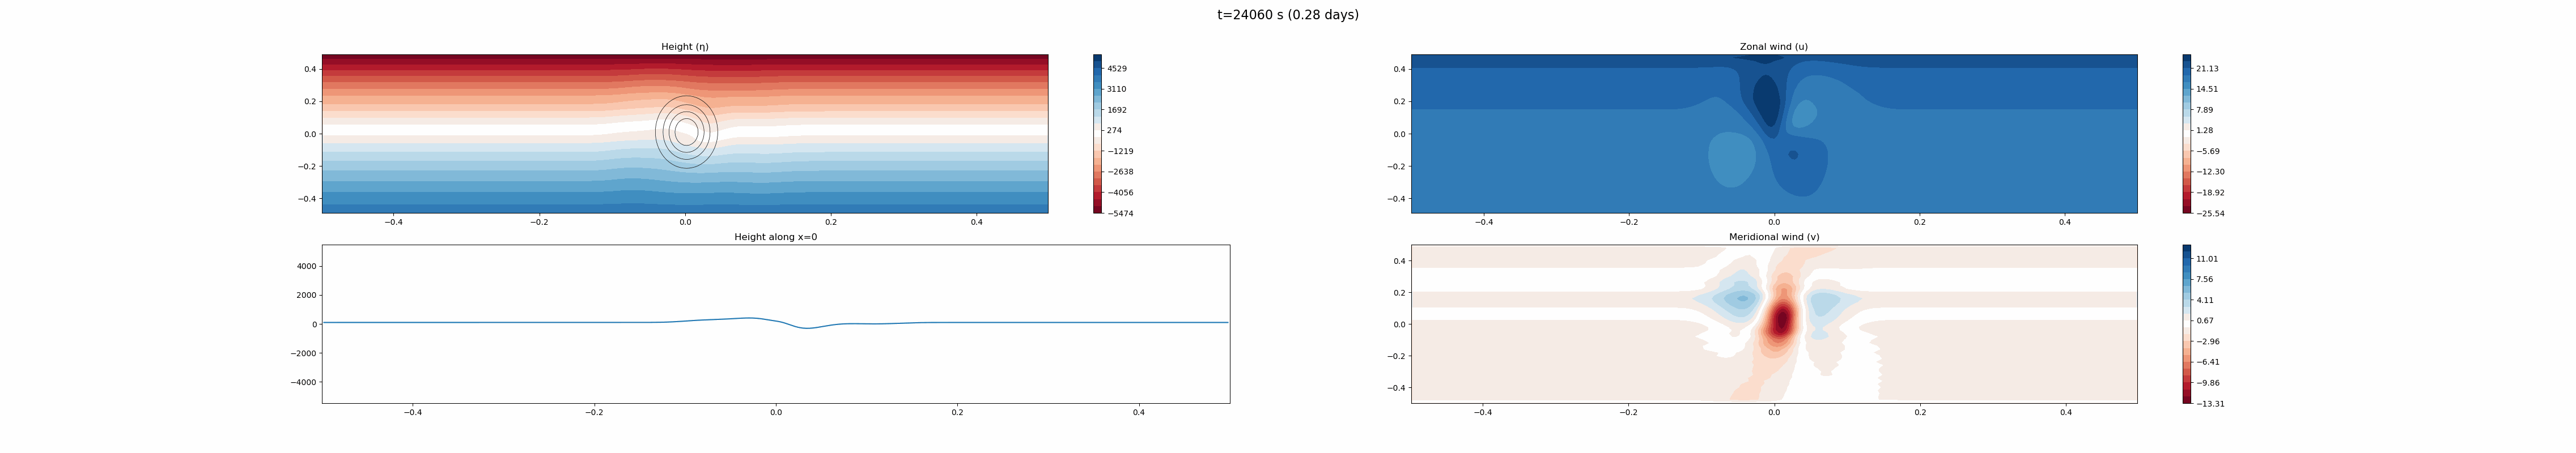

In [162]:
gif_filepath = dir_figs+'/animation.gif'
make_animation(gif_filepath)